<a href="https://colab.research.google.com/github/yuancx2025/526_project_group2/blob/main/Flight_Prices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#This is downloading the file and storing it in temporary storage as a csv (the file type from kaggle)
#Only needs to be run once

!pip install -q kaggle
!pip install --upgrade polars
from google.colab import files

# Upload the kaggle.json file from your computer
uploaded = files.upload()

# Move it into place
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d dilwong/flightprices -p /content/data
!unzip /content/data/flightprices.zip -d /content/data

In [ ]:
#This is mounting to Google Drive, converting the files to parquet, and storing the parquet files in drive to avoid losing them after runtime restart
#At the end, there should be 83 files (part 0 to part 82)
#Only needs to be run once
#This cell and the above cell are AI generated code that has been tested and tweaked to complete the basic process of downloading and saving the data

from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount("/content/drive")

# Set output folder in Google Drive
output_directory = "/content/drive/MyDrive/flight_data/parquet_parts"
os.makedirs(output_directory, exist_ok=True)

# Read CSV in chunks and write directly to Google Drive
chunked_data = pd.read_csv("/content/data/itineraries.csv", chunksize=1_000_000)
for i, chunk in enumerate(chunked_data):
    output_file = f"{output_directory}/itineraries_part{i}.parquet"
    chunk.to_parquet(output_file, index=False)
    print(f"Saved {output_file}")


In [ ]:
!pip install pandas pyarrow

In [ ]:
#Calculating average fare by airline, without filtering out trips with multiple airlines yet

import glob
import pandas as pd

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

base_fare_list = []
total_fare_list = []
count_list = []

for file in data_files:
  airline_frame = pd.read_parquet(file, columns =["baseFare", "totalFare", "segmentsAirlineName"])
  cleaned_airline_frame = airline_frame.dropna()

  sum_of_airline_base_fare = cleaned_airline_frame.groupby("segmentsAirlineName")["baseFare"].sum()
  sum_of_airline_total_fare = cleaned_airline_frame.groupby("segmentsAirlineName")["totalFare"].sum()
  count_of_airline = cleaned_airline_frame.groupby("segmentsAirlineName")["totalFare"].count()

  base_fare_list.append(sum_of_airline_base_fare)
  total_fare_list.append(sum_of_airline_total_fare)
  count_list.append(count_of_airline)

combined_base_fare = pd.concat(base_fare_list)
combined_total_fare = pd.concat(total_fare_list)
combined_count = pd.concat(count_list)

grouped_base_fare = combined_base_fare.groupby("segmentsAirlineName").sum()
grouped_total_fare = combined_total_fare.groupby("segmentsAirlineName").sum()
grouped_count = combined_count.groupby("segmentsAirlineName").sum()

merged_fares = pd.merge(grouped_base_fare, grouped_total_fare, on="segmentsAirlineName")
fully_merged_frame = pd.merge(merged_fares, grouped_count, on="segmentsAirlineName")

fully_merged_frame["averageBaseFare"] = fully_merged_frame["baseFare"] / fully_merged_frame["totalFare_y"]
fully_merged_frame["averageTotalFare"] = fully_merged_frame["totalFare_x"] / fully_merged_frame["totalFare_y"]

fully_merged_frame_sorted = fully_merged_frame.reset_index().sort_values(by="averageTotalFare")
print(fully_merged_frame_sorted)

                                   segmentsAirlineName     baseFare  \
86                                   Frontier Airlines  44685912.72   
109                                    Spirit Airlines  58787896.43   
88   Frontier Airlines||Frontier Airlines||Frontier...   1264160.28   
23   American Airlines||American Airlines||Southern...    101102.20   
105  Southern Airways Express||American Airlines||A...     67311.42   
..                                                 ...          ...   
37                 Cape Air||Cape Air||Alaska Airlines      9915.73   
52                              Cape Air||Delta||Delta     12469.11   
124        United||Cape Air||Cape Air||Alaska Airlines     67690.25   
29                  American Airlines||JetBlue Airways   1230892.50   
94                  JetBlue Airways||American Airlines     41267.40   

     totalFare_x  totalFare_y  averageBaseFare  averageTotalFare  
86   54823685.62       466926        95.702344        117.414078  
109  97914082

In [ ]:
# Display the whole result
display(fully_merged_frame_sorted.head(1000))

,segmentsAirlineName,baseFare,totalFare_x,totalFare_y,averageBaseFare,averageTotalFare
86,Frontier Airlines,44685912.72,54823685.62,466926,95.702344,117.414078
109,Spirit Airlines,58787896.43,97914082.10,735728,79.904389,133.084621
88,Frontier Airlines||Frontier Airlines||Frontier...,1264160.28,1638336.37,8507,148.602360,192.586854
23,American Airlines||American Airlines||Southern...,101102.20,126696.68,649,155.781510,195.218305
105,Southern Airways Express||American Airlines||A...,67311.42,81795.94,409,164.575599,199.990073
...,...,...,...,...,...,...
37,Cape Air||Cape Air||Alaska Airlines,9915.73,10774.02,6,1652.621667,1795.670000
52,Cape Air||Delta||Delta,12469.11,13538.00,7,1781.301429,1934.000000
124,United||Cape Air||Cape Air||Alaska Airlines,67690.25,73711.87,36,1880.284722,2047.551944
29,American Airlines||JetBlue Airways,1230892.50,1330621.81,388,3172.403351,3429.437655


Index(['segmentsAirlineName', 'baseFare', 'totalFare_x', 'totalFare_y',
       'averageBaseFare', 'averageTotalFare'],
      dtype='object')


In [ ]:
#Display only single airline elements
filtered_airline_prices = fully_merged_frame_sorted[~fully_merged_frame_sorted["segmentsAirlineName"].str.contains("\\|\\|")]
display(filtered_airline_prices.head(1000))

,segmentsAirlineName,baseFare,totalFare_x,totalFare_y,averageBaseFare,averageTotalFare
86,Frontier Airlines,4.468591e+07,5.482369e+07,466926,95.702344,117.414078
109,Spirit Airlines,5.878790e+07,9.791408e+07,735728,79.904389,133.084621
93,JetBlue Airways,7.028261e+08,8.073614e+08,3578393,196.408298,225.621213
58,Delta,1.105934e+09,1.259465e+09,4855169,227.784896,259.407132
113,United,1.037730e+09,1.181545e+09,4531426,229.007291,260.744611
18,American Airlines,1.778479e+09,2.019509e+09,7453245,238.618068,270.957022
0,Alaska Airlines,1.069194e+08,1.214501e+08,446001,239.729142,272.309032


In [ ]:
#Calculating average fares by Days Until Flight

import matplotlib.pyplot as plt
import glob
import pandas as pd

time_to_flight_list = []

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

for file in data_files:
  time_to_flight_frame = pd.read_parquet(file, columns =["baseFare", "totalFare", "searchDate", "flightDate"])
  cleaned_time_to_flight_frame = time_to_flight_frame.dropna()

  cleaned_time_to_flight_frame["searchDate"] = pd.to_datetime(cleaned_time_to_flight_frame["searchDate"], format = '%Y-%m-%d')
  cleaned_time_to_flight_frame["flightDate"] = pd.to_datetime(cleaned_time_to_flight_frame['flightDate'], format = '%Y-%m-%d')

  cleaned_time_to_flight_frame["daysUntilFlight"] = (cleaned_time_to_flight_frame["flightDate"] - cleaned_time_to_flight_frame["searchDate"]).dt.days

  time_to_flight_list.append(cleaned_time_to_flight_frame)

combined_time_to_flight = pd.concat(time_to_flight_list)

grouped_data = combined_time_to_flight.groupby("daysUntilFlight").agg({"baseFare": "mean", "totalFare": "mean"})

grouped_data_sorted = grouped_data.reset_index().sort_values(by="daysUntilFlight")

print(grouped_data_sorted)


    daysUntilFlight    baseFare   totalFare
0                 1  337.281883  387.709612
1                 2  320.312157  369.764160
2                 3  321.529865  371.191801
3                 4  323.320186  373.210412
4                 5  322.162095  371.993331
5                 6  307.995929  356.858144
6                 7  303.978813  352.495203
7                 8  304.121931  352.629336
8                 9  303.113436  351.553238
9                10  302.789353  351.220050
10               11  304.402804  352.961486
11               12  305.893542  354.536841
12               13  304.995641  353.579057
13               14  291.654689  339.130482
14               15  292.483531  339.986018
15               16  293.041377  340.530011
16               17  293.633808  341.113577
17               18  295.364529  342.951856
18               19  294.900758  342.487600
19               20  293.574376  341.190622
20               21  289.918640  337.381601
21               22  291.824535 

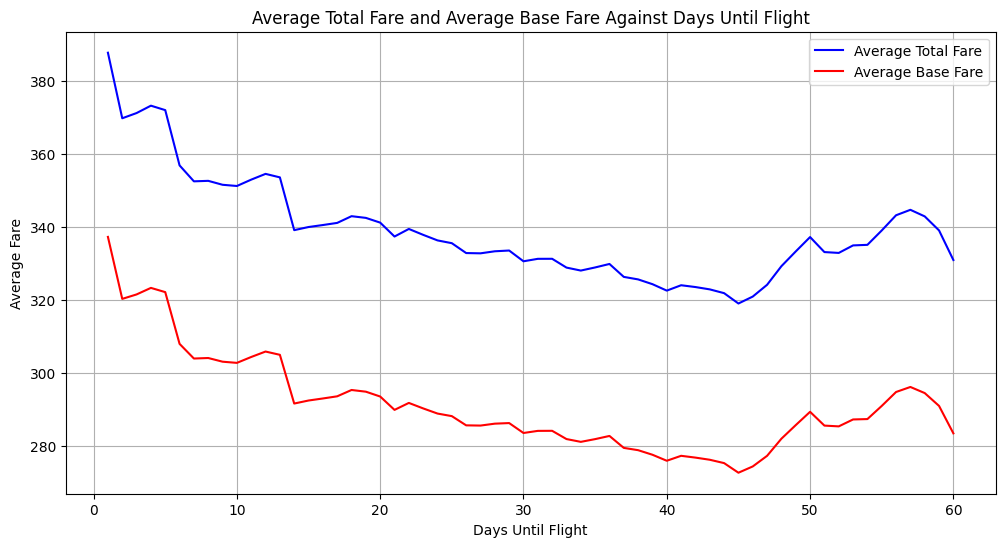

In [ ]:
#Graphs Total and Base Fare vs Days Until Flight

plt.figure(figsize=(12, 6))

plt.plot(grouped_data_sorted["daysUntilFlight"], grouped_data_sorted["totalFare"], label = "Average Total Fare", color = "blue")
plt.plot(grouped_data_sorted["daysUntilFlight"], grouped_data_sorted["baseFare"], label = "Average Base Fare", color = "red")

plt.xlabel("Days Until Flight")
plt.ylabel("Average Fare")
plt.title("Average Total Fare and Average Base Fare Against Days Until Flight")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Calculating average fares by Seats Remaining

import matplotlib.pyplot as plt
import glob
import pandas as pd

seats_to_flight_list = []

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

for file in data_files:
  seats_to_flight_frame = pd.read_parquet(file, columns =["baseFare", "totalFare", "seatsRemaining"])
  cleaned_seats_to_flight_frame = seats_to_flight_frame.dropna()

  seats_to_flight_list.append(cleaned_seats_to_flight_frame)

combined_seats_to_flight = pd.concat(seats_to_flight_list)

grouped_data = combined_seats_to_flight.groupby("seatsRemaining").agg({"baseFare": "mean", "totalFare": "mean"})

grouped_data_sorted = grouped_data.reset_index().sort_values(by="seatsRemaining")

grouped_data_sorted = grouped_data_sorted.drop(0)

print(grouped_data_sorted)

    seatsRemaining    baseFare   totalFare
1                1  351.028574  400.875533
2                2  344.631767  393.931135
3                3  344.642018  394.012678
4                4  298.214684  343.311710
5                5  340.369320  389.031436
6                6  340.935533  389.535098
7                7  278.427822  320.736697
8                8  358.729340  408.704247
9                9  300.578891  345.471036
10              10  284.347758  325.848302


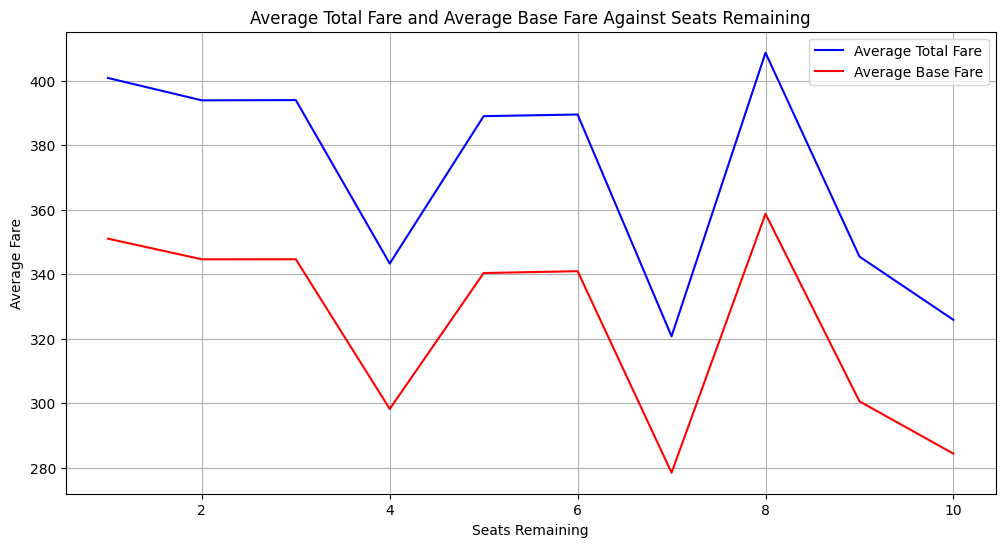

In [ ]:
#Graphs Total and Base Fare vs Days Until Flight

plt.figure(figsize=(12, 6))

plt.plot(grouped_data_sorted["seatsRemaining"], grouped_data_sorted["totalFare"], label = "Average Total Fare", color = "blue")
plt.plot(grouped_data_sorted["seatsRemaining"], grouped_data_sorted["baseFare"], label = "Average Base Fare", color = "red")

plt.xlabel("Seats Remaining")
plt.ylabel("Average Fare")
plt.title("Average Total Fare and Average Base Fare Against Seats Remaining")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Calculating average fares by Departure Airport

import matplotlib.pyplot as plt
import glob
import pandas as pd

airport_to_flight_list = []

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

for file in data_files:
  airport_to_flight_frame = pd.read_parquet(file, columns =["baseFare", "totalFare", "startingAirport"])
  cleaned_airport_to_flight_frame = airport_to_flight_frame.dropna()

  airport_to_flight_list.append(cleaned_airport_to_flight_frame)

combined_airport_to_flight = pd.concat(airport_to_flight_list)

grouped_data = combined_airport_to_flight.groupby("startingAirport").agg({"baseFare": "mean", "totalFare": "mean"})

grouped_data_sorted = grouped_data.reset_index().sort_values(by="startingAirport")


print(grouped_data_sorted)

   startingAirport    baseFare   totalFare
0              ATL  256.286357  303.774077
1              BOS  244.397564  285.865775
2              CLT  277.533362  321.456261
3              DEN  289.248307  335.077884
4              DFW  247.916803  294.077856
5              DTW  281.438523  330.940539
6              EWR  256.333672  302.986457
7              IAD  322.482141  370.046151
8              JFK  328.772712  375.406488
9              LAX  327.814189  379.254937
10             LGA  255.743809  299.220774
11             MIA  254.182362  299.955595
12             OAK  466.150221  534.211396
13             ORD  238.378007  281.691875
14             PHL  294.839088  344.088743
15             SFO  382.820888  434.504077


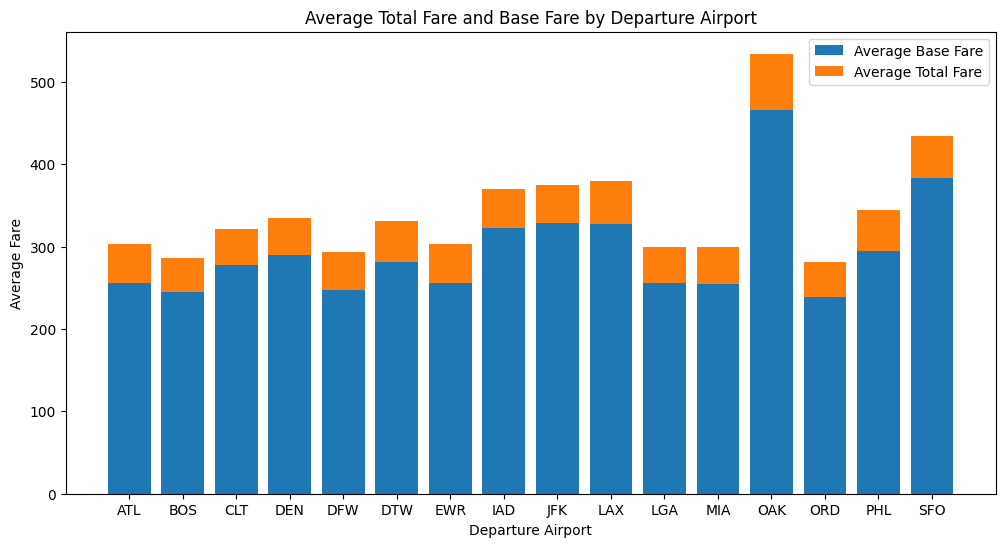

In [ ]:
#Graphs Total and Base Fare vs Departure Airport

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.bar(grouped_data_sorted["startingAirport"], grouped_data_sorted["baseFare"], label = "Average Base Fare")
plt.bar(grouped_data_sorted["startingAirport"], grouped_data_sorted["totalFare"] - grouped_data_sorted["baseFare"], bottom = grouped_data_sorted["baseFare"], label = "Average Total Fare")

plt.xlabel('Departure Airport')
plt.ylabel('Average Fare')
plt.title('Average Total Fare and Base Fare by Departure Airport')

plt.legend()
plt.show()

In [ ]:
#Calculating average fares by Arrival Airport

import matplotlib.pyplot as plt
import glob
import pandas as pd

airport_to_flight_list = []

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

for file in data_files:
  airport_to_flight_frame = pd.read_parquet(file, columns =["baseFare", "totalFare", "destinationAirport"])
  cleaned_airport_to_flight_frame = airport_to_flight_frame.dropna()

  airport_to_flight_list.append(cleaned_airport_to_flight_frame)

combined_airport_to_flight = pd.concat(airport_to_flight_list)

grouped_data = combined_airport_to_flight.groupby("destinationAirport").agg({"baseFare": "mean", "totalFare": "mean"})

grouped_data_sorted = grouped_data.reset_index().sort_values(by="destinationAirport")


print(grouped_data_sorted)

   destinationAirport    baseFare   totalFare
0                 ATL  261.373313  307.813053
1                 BOS  256.389185  298.714920
2                 CLT  280.352053  326.427466
3                 DEN  292.669705  338.768767
4                 DFW  253.624303  300.812487
5                 DTW  287.828807  338.556244
6                 EWR  268.631806  315.721903
7                 IAD  320.358696  367.485806
8                 JFK  325.796606  371.989837
9                 LAX  306.786886  356.976533
10                LGA  255.619853  298.707090
11                MIA  254.021005  298.510099
12                OAK  462.229386  530.599937
13                ORD  248.984740  293.253933
14                PHL  307.480352  357.491675
15                SFO  368.516365  418.759590


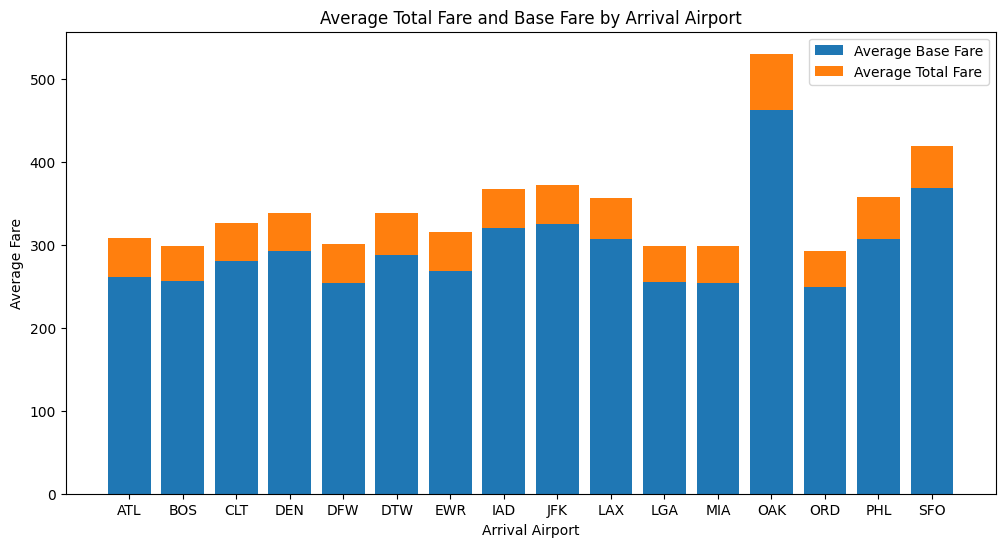

In [ ]:
#Graphs Total and Base Fare vs Arrival Airport

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.bar(grouped_data_sorted["destinationAirport"], grouped_data_sorted["baseFare"], label = "Average Base Fare")
plt.bar(grouped_data_sorted["destinationAirport"], grouped_data_sorted["totalFare"] - grouped_data_sorted["baseFare"], bottom = grouped_data_sorted["baseFare"], label = "Average Total Fare")

plt.xlabel('Arrival Airport')
plt.ylabel('Average Fare')
plt.title('Average Total Fare and Base Fare by Arrival Airport')

plt.legend()
plt.show()

In [ ]:
#Calculating average fares by Total Travel Distance

import matplotlib.pyplot as plt
import glob
import pandas as pd

seats_to_flight_list = []

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

for file in data_files:
  seats_to_flight_frame = pd.read_parquet(file, columns =["baseFare", "totalFare", "totalTravelDistance"])
  cleaned_seats_to_flight_frame = seats_to_flight_frame.dropna()

  seats_to_flight_list.append(cleaned_seats_to_flight_frame)

combined_seats_to_flight = pd.concat(seats_to_flight_list)

grouped_data = combined_seats_to_flight.groupby("totalTravelDistance").agg({"baseFare": "mean", "totalFare": "mean"})

grouped_data_sorted = grouped_data.reset_index().sort_values(by="totalTravelDistance")

grouped_data_sorted = grouped_data_sorted.drop(0)

print(grouped_data_sorted)

      totalTravelDistance     baseFare    totalFare
1                    97.0   226.211027   257.778055
2                   121.0   628.676185   690.428439
3                   185.0   108.740847   131.498911
4                   186.0   123.292354   147.139288
5                   191.0   106.086412   128.642130
...                   ...          ...          ...
3240               4498.0  1203.242952  1324.120773
3241               4636.0  1082.790000  1192.100000
3242               4654.0  1201.029000  1322.565500
3243               4681.0   558.140000   628.100000
3244               7252.0   829.431111   881.312222

[3244 rows x 3 columns]


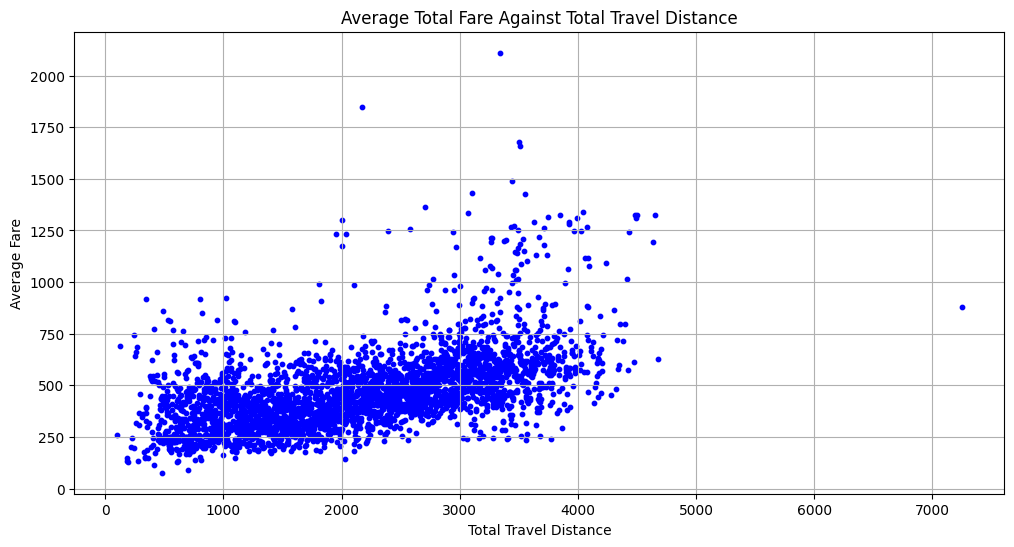

In [ ]:
#Graphs Total Fare vs Total Travel Distance

plt.figure(figsize=(12, 6))

plt.scatter(grouped_data_sorted["totalTravelDistance"], grouped_data_sorted["totalFare"], label = "Average Total Fare", color = "blue", s=10)

plt.xlabel("Total Travel Distance")
plt.ylabel("Average Fare")
plt.title("Average Total Fare Against Total Travel Distance")

plt.grid(True)
plt.show()

In [9]:
#Calculating Monopoly or Oligopoly on the 240 nonstop routes
from google.colab import drive
drive.mount("/content/drive")

import matplotlib.pyplot as plt
import glob
import pandas as pd

moo_data_list = []

data_files = glob.glob("/content/drive/MyDrive/flight_data/parquet_parts/*.parquet")

for file in data_files:
  monopoly_or_oligopoly_frame = pd.read_parquet(file, columns =["startingAirport", "destinationAirport", "segmentsAirlineName"])
  cleaned_moo_frame = monopoly_or_oligopoly_frame.dropna()
  cleaned_moo_frame = cleaned_moo_frame[~cleaned_moo_frame["segmentsAirlineName"].str.contains("\\|\\|")]

  moo_data_list.append(cleaned_moo_frame)

combined_moo_data = pd.concat(moo_data_list)

grouped_data_start = counts_by_category = combined_moo_data.groupby('startingAirport')['segmentsAirlineName'].value_counts()
grouped_data_dest = counts_by_category = combined_moo_data.groupby('destinationAirport')['segmentsAirlineName'].value_counts()
grouped_data_path = counts_by_category = combined_moo_data.groupby(['startingAirport', 'destinationAirport'], as_index = False)['segmentsAirlineName'].value_counts()

grouped_data_start_sorted = grouped_data_start.reset_index().sort_values(by="startingAirport")
grouped_data_dest_sorted = grouped_data_dest.reset_index().sort_values(by="destinationAirport")
grouped_data_path_sorted = grouped_data_path.reset_index().sort_values(by="startingAirport")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
print(grouped_data_start_sorted)

   startingAirport segmentsAirlineName    count
0              ATL               Delta  1031841
1              ATL   American Airlines   302932
2              ATL              United   154989
3              ATL     Spirit Airlines    97987
4              ATL   Frontier Airlines    81053
..             ...                 ...      ...
93             SFO              United   460686
94             SFO   American Airlines   333652
95             SFO               Delta   193268
96             SFO     Alaska Airlines   166457
98             SFO   Frontier Airlines    34144

[99 rows x 3 columns]


In [11]:
print(grouped_data_dest_sorted)

    destinationAirport segmentsAirlineName    count
0                  ATL               Delta  1024607
1                  ATL   American Airlines   301242
2                  ATL              United   153817
3                  ATL     Spirit Airlines    97616
4                  ATL   Frontier Airlines    80513
..                 ...                 ...      ...
97                 SFO              United   463223
98                 SFO   American Airlines   335645
99                 SFO               Delta   194260
100                SFO     Alaska Airlines   166318
102                SFO   Frontier Airlines    34247

[103 rows x 3 columns]


In [14]:
display(grouped_data_path_sorted)

,index,startingAirport,destinationAirport,segmentsAirlineName,count
0,0,ATL,BOS,Delta,89884
28,28,ATL,LAX,Spirit Airlines,12173
29,29,ATL,LAX,Alaska Airlines,8406
30,30,ATL,LAX,American Airlines,8406
31,31,ATL,LAX,Frontier Airlines,67
...,...,...,...,...,...
627,627,SFO,DTW,Alaska Airlines,5
628,628,SFO,DTW,JetBlue Airways,5
629,629,SFO,DTW,United,2
619,619,SFO,DEN,American Airlines,8


In [20]:
total_flights_per_route = (grouped_data_path_sorted.groupby(['startingAirport', 'destinationAirport'])['count'].sum()).reset_index()

flights_per_route_merged = pd.merge(grouped_data_path_sorted, total_flights_per_route, on=['startingAirport', 'destinationAirport'])

flights_per_route_merged["market_share"] = flights_per_route_merged["count_x"] / flights_per_route_merged["count_y"]

display(flights_per_route_merged)

,index,startingAirport,destinationAirport,segmentsAirlineName,count_x,count_y,market_share
0,0,ATL,BOS,Delta,89884,114860,0.782553
1,28,ATL,LAX,Spirit Airlines,12173,147829,0.082345
2,29,ATL,LAX,Alaska Airlines,8406,147829,0.056863
3,30,ATL,LAX,American Airlines,8406,147829,0.056863
4,31,ATL,LAX,Frontier Airlines,67,147829,0.000453
...,...,...,...,...,...,...,...
652,627,SFO,DTW,Alaska Airlines,5,30195,0.000166
653,628,SFO,DTW,JetBlue Airways,5,30195,0.000166
654,629,SFO,DTW,United,2,30195,0.000066
655,619,SFO,DEN,American Airlines,8,97269,0.000082


In [34]:
import numpy as np

unique_starts = np.sort(flights_per_route_merged['startingAirport'].unique())
unique_ends = np.sort(flights_per_route_merged['destinationAirport'].unique())
column_names = ["Departure Airport", "Arrival Airport", "HHI Index", "Market Type"]
market_types = pd.DataFrame(columns=column_names)

for start in unique_starts:
  for end in unique_ends:
    HHI = 0
    filtered_df = flights_per_route_merged[(flights_per_route_merged['startingAirport'] == start) & (flights_per_route_merged['destinationAirport'] == end)]
    for index, row_data in filtered_df.iterrows():
      HHI += (row_data["market_share"])**2
    if HHI > .6:
      market_kind = "Monopoly"
    elif HHI > .2:
      market_kind = "Oligopoly"
    elif HHI > 0:
      market_kind = "Competitive"
    else:
      market_kind = "No Flights"
    new_path_row = pd.DataFrame([{"Departure Airport": start, "Arrival Airport": end, "HHI Index": HHI, "Market Type": market_kind}])
    market_types = pd.concat([market_types, new_path_row])


display(market_types)

,Departure Airport,Arrival Airport,HHI Index,Market Type
0,ATL,ATL,0,No Flights
0,ATL,BOS,0.634026,Monopoly
0,ATL,CLT,0.502447,Oligopoly
0,ATL,DEN,0.472373,Oligopoly
0,ATL,DFW,0.438841,Oligopoly
...,...,...,...,...
0,SFO,MIA,0.941009,Monopoly
0,SFO,OAK,0,No Flights
0,SFO,ORD,0.554931,Oligopoly
0,SFO,PHL,0.584525,Oligopoly


from matplotlib import pyplot as plt
import seaborn as sns
market_types.groupby('Market Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)